In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
41589,NaN,NaN,International,2020-09-02,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41590,NaN,NaN,International,2020-09-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41591,NaN,NaN,International,2020-09-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


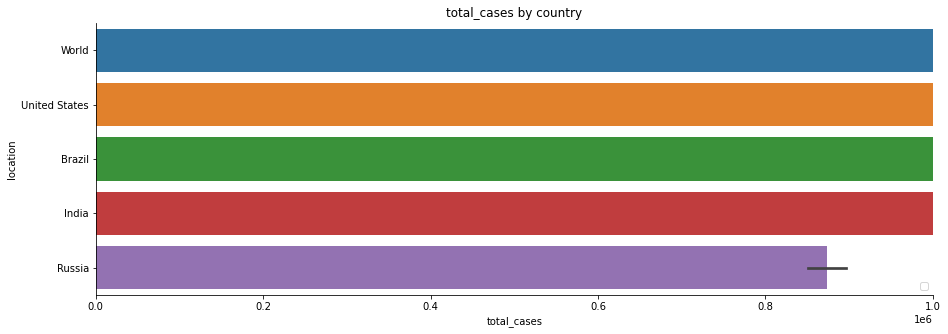

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


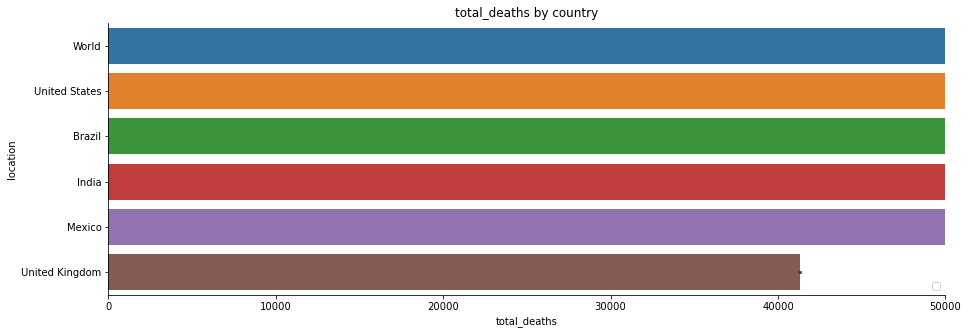

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


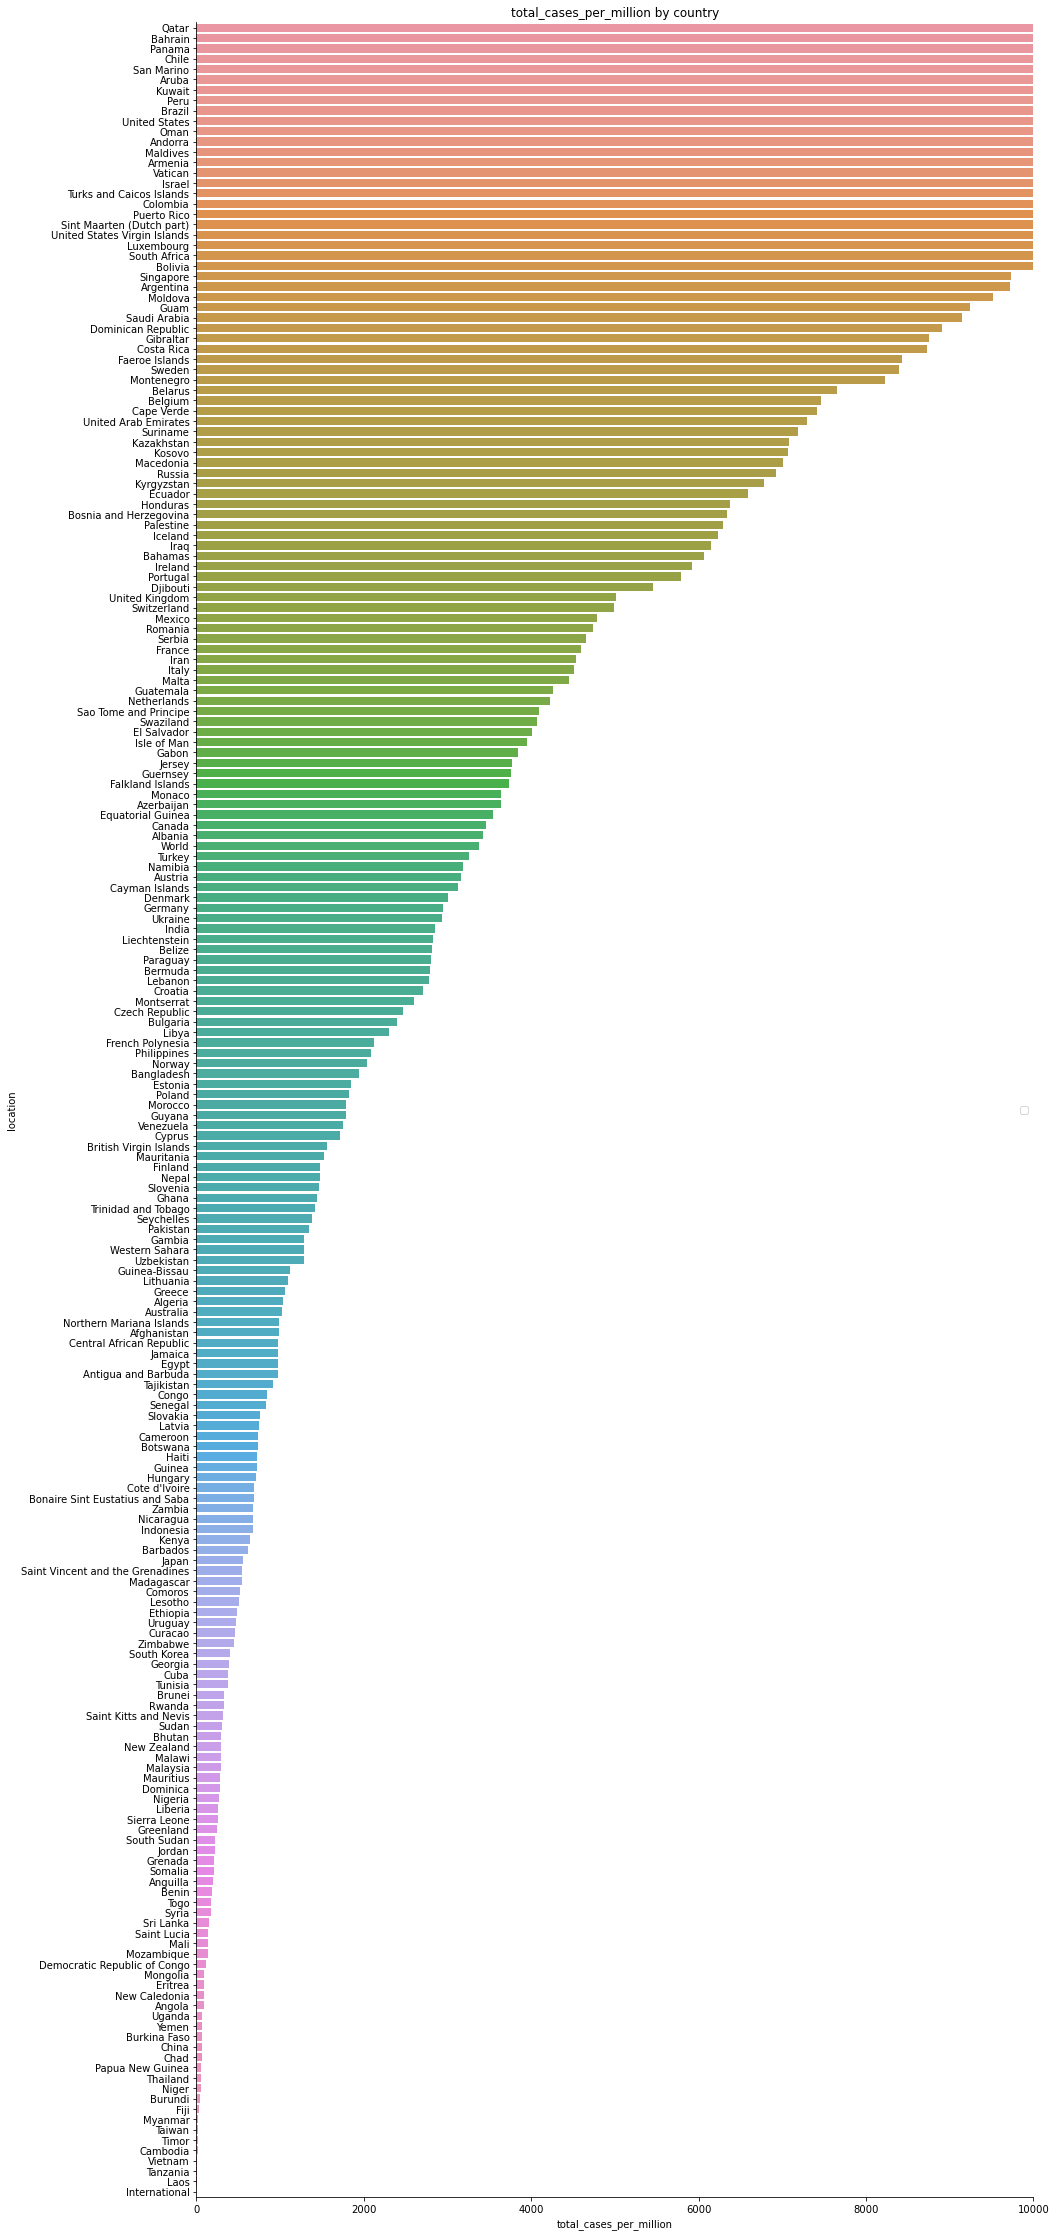

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


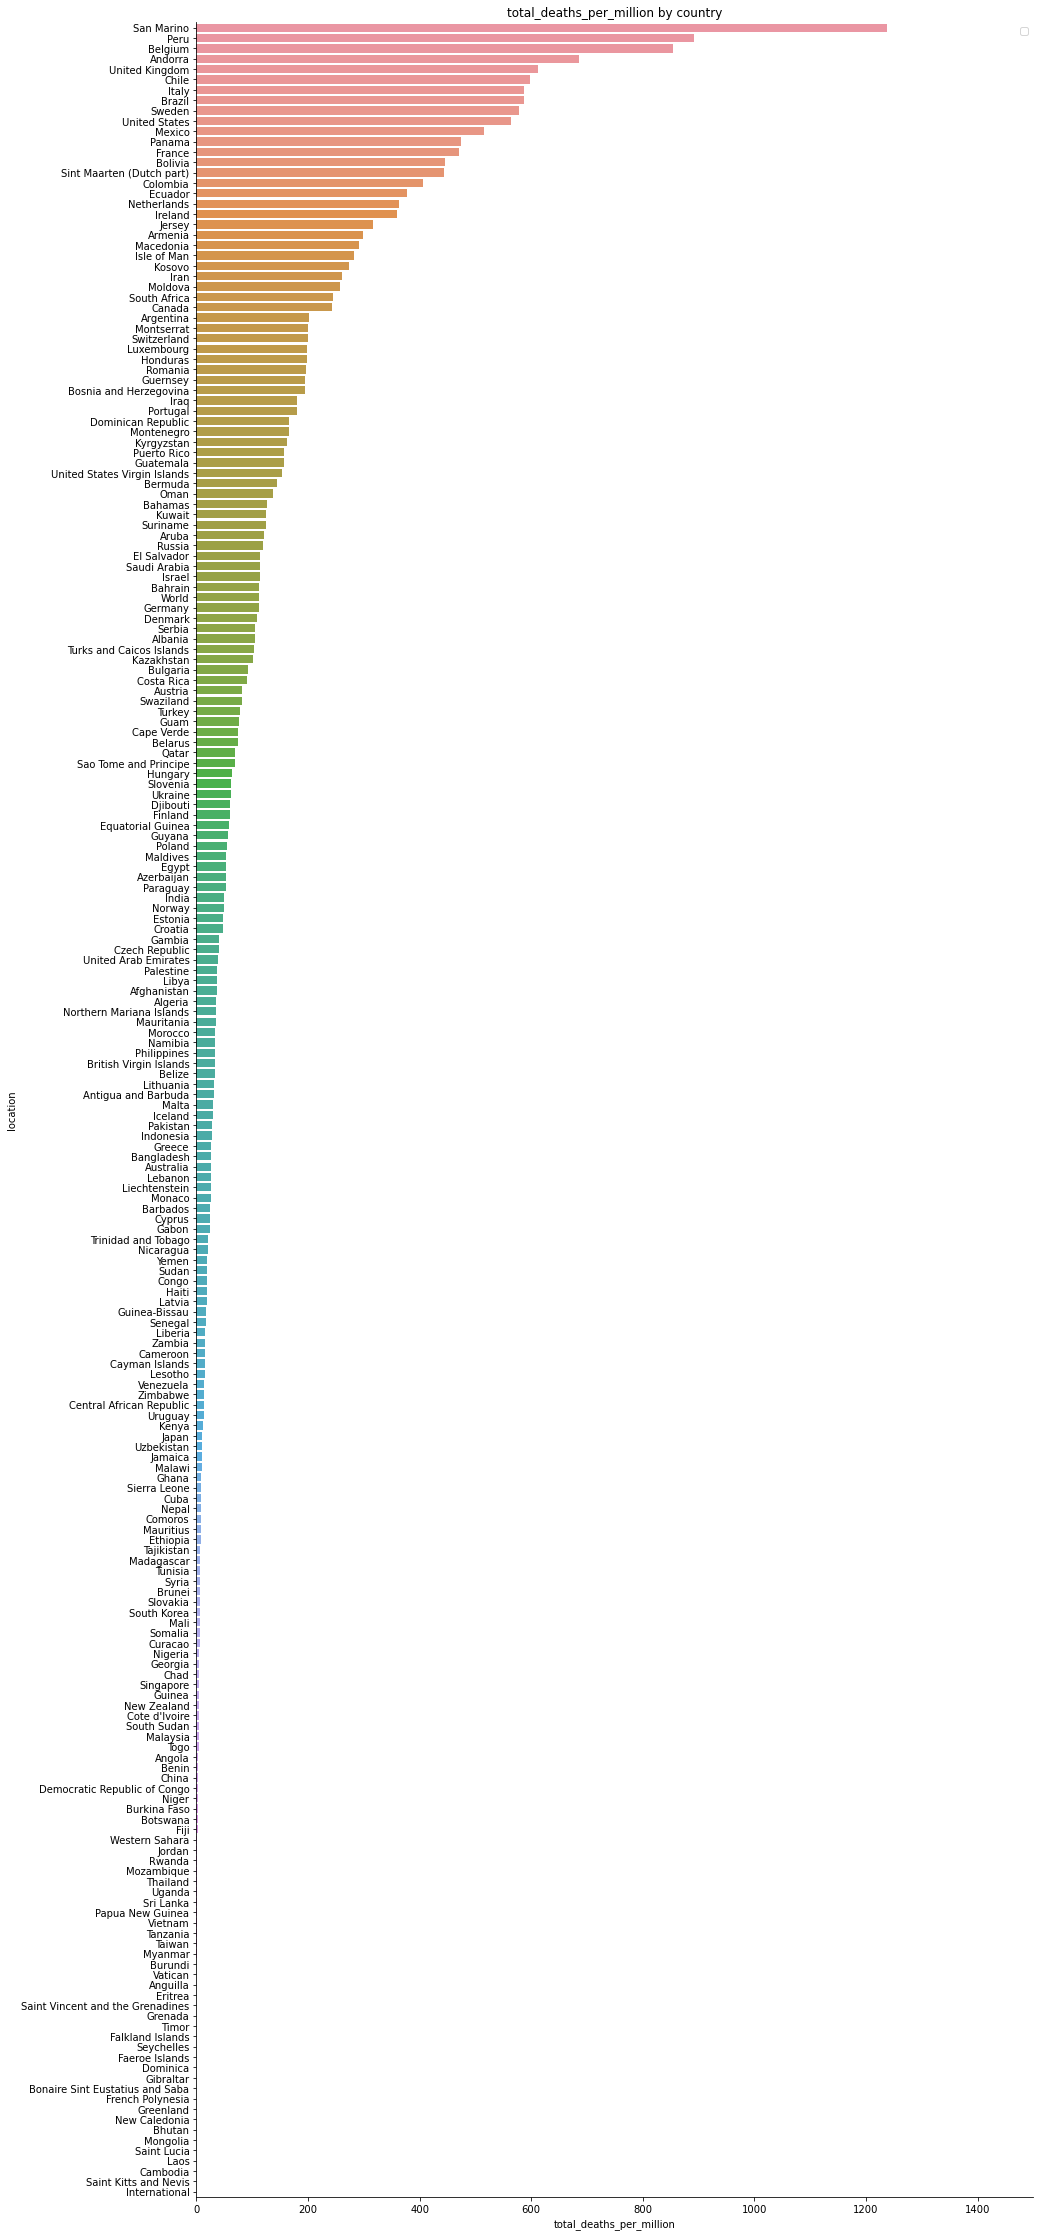

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

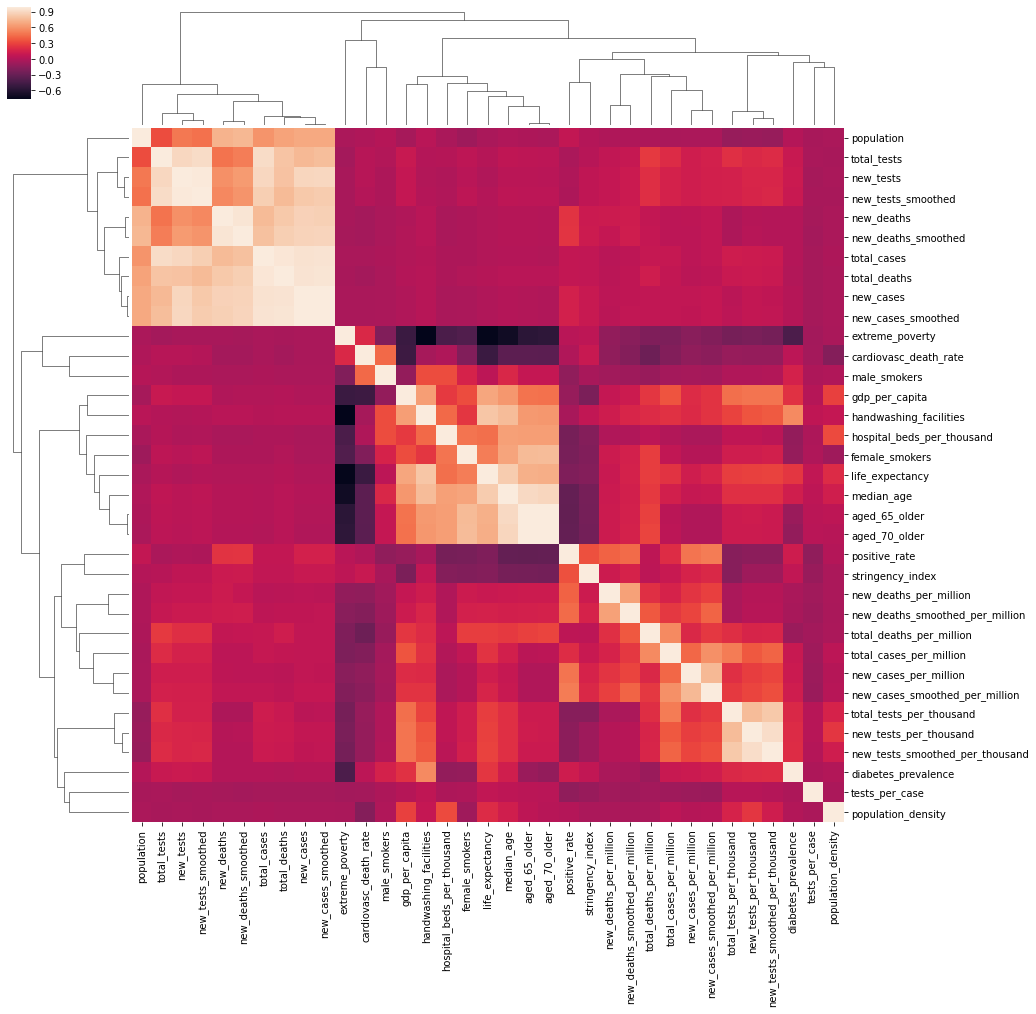

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9992299166068318 (+/- 0.0007688296899505873)
Coef :  [1.03617502e+00 9.22213189e-05 9.53801591e-05]
3 Last_days :  [[25786241 26068854 26335685]]
Today :  26335685
Prediction + :  474833
Tomorow :  26810518
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996776570968224 (+/- 6.31923038040649e-05)
Coef :  [0.07595047 0.45274898 0.48146723]
3 Last_days :  [[857508 863584 869209]]
Today :  869209
Prediction + :  8110
Tomorow :  877319
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9936750461610621 (+/- 0.002970193657233859)
Coef :  [-0.71565806  0.75130625  0.96716045]
3 Last_days :  [[286007 293024 300181]]
Today :  300181
Prediction + :  5749
Tomorow :  305930
                                     
--------- Total Death -----------------
                                     
R^2: 0.5604382680382344 (+/- 0.6122664882496556)
Coef :  [-0.75146274  0.78869507  0.96179   ]
3 Last_days :  [[30661 30686 30706]]
Today :  30706
Prediction + :  40
Tomorow :  30746
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9293772664517364 (+/- 0.05517631928931332)
Coef :  [-0.32580822 -0.01777033  1.33784652]
3 Last_days :  [[89934 89953 89986]]
Today :  89986
Prediction + :  29
Tomorow :  90015
                                     
--------- Total Death -----------------
                                     
R^2: -146.6327193316467 (+/- 208.65750887056979)
Coef :  [-0.07706721  0.01244348  1.05651205]
3 Last_days :  [[4724 4727 4735]]
Today :  4735
Prediction + :  6
Tomorow :  4741
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.961294465907878 (+/- 0.05373746020819973)
Coef :  [-0.82522454  0.89881865  0.92571344]
3 Last_days :  [[270189 271515 272912]]
Today :  272912
Prediction + :  1188
Tomorow :  274100
                                     
--------- Total Death -----------------
                                     
R^2: 0.6816859497280152 (+/- 0.42379900519698044)
Coef :  [-0.82744691  0.89903497  0.92750749]
3 Last_days :  [[35491 35497 35507]]
Today :  35507
Prediction + :  25
Tomorow :  35532
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9266297181113518 (+/- 0.09412859649270205)
Coef :  [-0.47561773  0.29837297  1.18008299]
3 Last_days :  [[470973 479554 488513]]
Today :  488513
Prediction + :  7315
Tomorow :  495828
                                     
--------- Total Death -----------------
                                     
R^2: 0.08617642254990103 (+/- 1.0567086777183599)
Coef :  [-0.72624507  0.62852371  1.09671677]
3 Last_days :  [[29152 29194 29234]]
Today :  29234
Prediction + :  42
Tomorow :  29276
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.980554894046047 (+/- 0.027164011497241927)
Coef :  [0.07689162 0.46488621 0.47339505]
3 Last_days :  [[6075652 6114406 6150655]]
Today :  6150655
Prediction + :  85134
Tomorow :  6235789
                                     
--------- Total Death -----------------
                                     
R^2: 0.9804745338344875 (+/- 0.026391524258774134)
Coef :  [-0.51429783  0.72019884  0.79678938]
3 Last_days :  [[184689 185744 186797]]
Today :  186797
Prediction + :  1169
Tomorow :  187966
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9286147036955281 (+/- 0.10037685003731599)
Coef :  [-0.72297389  0.84942435  0.87375119]
3 Last_days :  [[337168 338676 340411]]
Today :  340411
Prediction + :  1475
Tomorow :  341886
                                     
--------- Total Death -----------------
                                     
R^2: 0.34968808844277377 (+/- 0.8803942803870374)
Coef :  [-0.77090935  0.83166216  0.93862107]
3 Last_days :  [[41504 41514 41527]]
Today :  41527
Prediction + :  43
Tomorow :  41570
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.945930159697446 (+/- 0.07407742094308518)
Coef :  [-0.7945914   0.8563996   0.93787321]
3 Last_days :  [[244855 246116 246948]]
Today :  246948
Prediction + :  1184
Tomorow :  248132
                                     
--------- Total Death -----------------
                                     
R^2: 0.35791016133575754 (+/- 0.8974964348612294)
Coef :  [-0.79038129  0.84089639  0.948783  ]
3 Last_days :  [[9313 9319 9319]]
Today :  9319
Prediction + :  11
Tomorow :  9330
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -18.775563830535393 (+/- 27.965398118172196)
Coef :  [0.23032986 0.39076183 0.39011205]
3 Last_days :  [[376894 378752 380746]]
Today :  380746
Prediction + :  4003
Tomorow :  384749
                                     
--------- Total Death -----------------
                                     
R^2: 0.9542432970674605 (+/- 0.06410577387098923)
Coef :  [0.01621794 0.50179159 0.49353789]
3 Last_days :  [[21672 21797 21926]]
Today :  21926
Prediction + :  239
Tomorow :  22165
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9980189811728056 (+/- 0.0025042513377229207)
Coef :  [-0.72345504  0.84229049  0.87854391]
3 Last_days :  [[271705 273301 274943]]
Today :  274943
Prediction + :  1296
Tomorow :  276239
                                     
--------- Total Death -----------------
                                     
R^2: 0.9989728755369613 (+/- 0.0009083228963408152)
Coef :  [-0.81016292  0.89279207  0.91467625]
3 Last_days :  [[6417 6462 6511]]
Today :  6511
Prediction + :  36
Tomorow :  6547
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.44852588749300554 (+/- 0.7757830864975217)
Coef :  [-0.11635609  0.49587955  0.63680877]
3 Last_days :  [[3950931 3997865 4041638]]
Today :  4041638
Prediction + :  61599
Tomorow :  4103237
                                     
--------- Total Death -----------------
                                     
R^2: 0.48387186937872295 (+/- 0.7280405524352708)
Coef :  [-0.0962049   0.51291315  0.59561633]
3 Last_days :  [[122596 123780 124614]]
Today :  124614
Prediction + :  1575
Tomorow :  126189
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(26335685, 869209, 26810518, 877319),
 (300181, 30706, 305930, 30746),
 (272912, 35507, 274100, 35532),
 (488513, 29234, 495828, 29276),
 (6150655, 186797, 6235789, 187966),
 (89986, 4735, 90015, 4741),
 (340411, 41527, 341886, 41570),
 (246948, 9319, 248132, 9330),
 (380746, 21926, 384749, 22165),
 (274943, 6511, 276239, 6547),
 (4041638, 124614, 4103237, 126189)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-04,France,305930.0,0.0,30746.0,0.0,0.0,0.0
0,2020-09-04,China,90015.0,0.0,4741.0,0.0,0.0,0.0
0,2020-09-04,Italy,274100.0,0.0,35532.0,0.0,0.0,0.0
0,2020-09-04,Spain,495828.0,0.0,29276.0,0.0,0.0,0.0
0,2020-09-04,United States,6235789.0,0.0,187966.0,0.0,0.0,0.0
0,2020-09-04,World,26810518.0,0.0,877319.0,0.0,0.0,0.0
0,2020-09-04,United Kingdom,341886.0,0.0,41570.0,0.0,0.0,0.0
0,2020-09-04,Germany,248132.0,0.0,9330.0,0.0,0.0,0.0
0,2020-09-04,Iran,384749.0,0.0,22165.0,0.0,0.0,0.0
0,2020-09-04,Turkey,276239.0,0.0,6547.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")